# Lower Back Pain Symptoms

## Notes
[Data Set Source](https://www.kaggle.com/sammy123/lower-back-pain-symptoms-dataset)   
1. pelvic_incidence
2. pelvic_tilt
3. lumbar_lordosis_angle
4. sacral_slope
5. pelvic_radius
6. degree_spondylolisthesis
7. pelvic_slope
8. Direct_tilt
9. thoracic_slope
10. cervical_tilt
11. sacrum_angle
12. scoliosis_slope



## Set up

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [19]:
# Reading file
path_to_file = "/content/drive/My Drive/backPain.csv" 

import csv

data = []
with open(path_to_file, mode='r') as csv_file:
    csv_reader = csv.reader(csv_file, delimiter=',') # csv.DictReader(csv_file)
    for row in csv_reader:
      data.append(row)
# Split title and data
trainingData = data[1:] 
fakeTitle = data[:1]
title = fakeTitle[0]
for i in range(0, 14):
  print(i, title[i])

0 Col1
1 Col2
2 Col3
3 Col4
4 Col5
5 Col6
6 Col7
7 Col8
8 Col9
9 Col10
10 Col11
11 Col12
12 Class_att
13 


In [20]:
# Dimension check
import numpy as np
x = np.array(trainingData)
print(np.shape(x))

(310, 14)


## Re-integrating the data

In [21]:
for i in range (0, 310):
  if x[i][12] == 'Abnormal':
    x[i][12] = 1
  elif x[i][12] == 'Normal':
    x[i][12] = 0

## Shuffling & Splitting the data set 

In [22]:
np.random.shuffle(x)
trainingSet = x[:270]
testingSet = x[270:]
print(np.shape(trainingSet))

(270, 14)


In [23]:
# A bunch of imports 
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import torch.optim as optim
from tqdm import tqdm_notebook

In [24]:
trainingInput = trainingSet[:,:12]
trainingOutput = trainingSet[:,12]
trainingInput = trainingInput.astype(np.float)
trainingOutput = trainingOutput.astype(np.float)
trainingOutput = torch.from_numpy(trainingOutput).float().reshape(-1,1)
print(np.shape(trainingOutput))
print(np.shape(trainingInput))

torch.Size([270, 1])
(270, 12)


## Actual Experiment

In [34]:
trainingFeatureNames = title[:-2] # TODO: Are we ending on index 12?
inData = {}
normalizationConstant = {}
for i, feature in enumerate(trainingFeatureNames):
  inData[i] = torch.from_numpy(trainingInput[:,i]).float().reshape(-1,1) # Can do by feature name or index
for i in inData:
  normalizationConstant[i] = torch.max(inData[i])
  inData[i] = inData[i] / normalizationConstant[i] # normalization 
print(np.shape(inData[11]))

torch.Size([270, 1])


In [26]:
# Create Net class
class Net(nn.Module):
  def __init__(self, layerWidth=300):
    super(Net, self).__init__();
    self.fc1 = nn.Linear(1, layerWidth)
    nn.init.kaiming_normal_(self.fc1.weight)
    self.fc2 = nn.Linear(layerWidth, layerWidth)
    nn.init.kaiming_normal_(self.fc2.weight)
    self.fc3 = nn.Linear(layerWidth, layerWidth)
    nn.init.kaiming_normal_(self.fc3.weight)
    self.fc4 = nn.Linear(layerWidth,1)
    nn.init.kaiming_normal_(self.fc4.weight)
  def forward (self, x):
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x

In [27]:
nets = []
for i in range(11):
  nets.append( Net() )

In [28]:
import torch.optim as optim
from tqdm import tqdm_notebook

optimizers = [optim.Adam(nets[i].parameters()) for i in range(len(nets))]

epochs = tqdm_notebook(range(2400))
criterion = nn.MSELoss()
for epoch in epochs:
  for optimizer in optimizers:
    optimizer.zero_grad()

  outputs = [nets[i](inData[i]) for i in range(len(nets))]

  totalOut = sum(outputs) # TODO: Check that this works.
  loss = criterion(totalOut,trainingOutput)
  loss.backward()

  for optimizer in optimizers:
    optimizer.step()

  epochs.set_description(str(loss.data.item()))

print(loss.data.item())

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:6: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  



0.055133529007434845


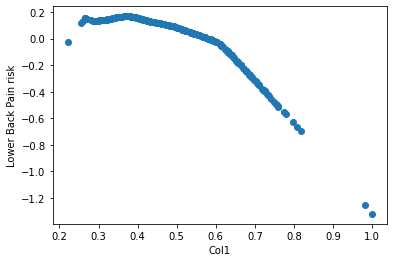

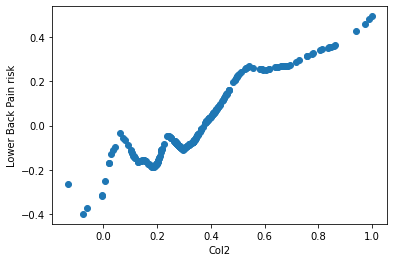

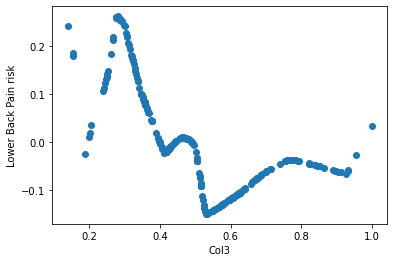

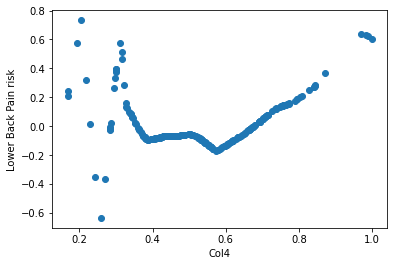

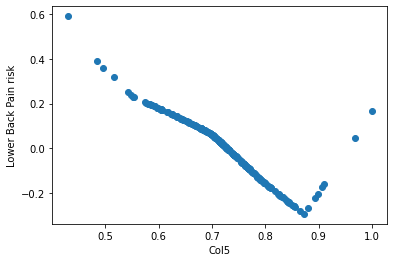

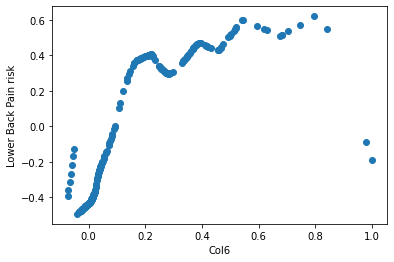

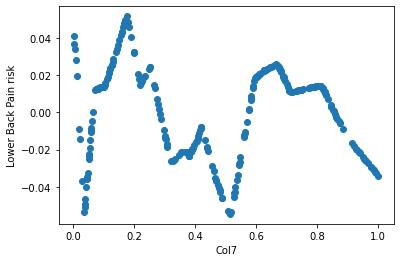

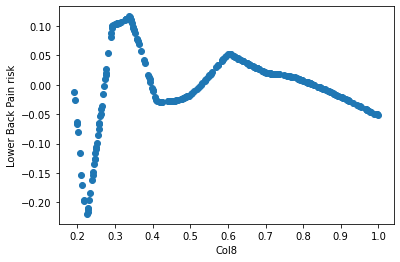

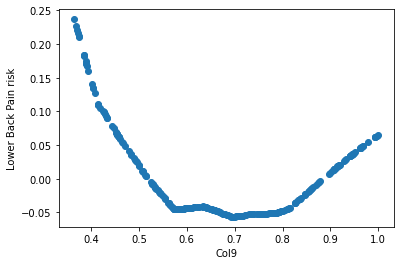

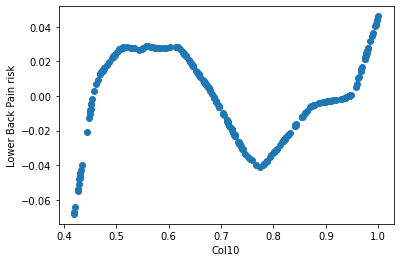

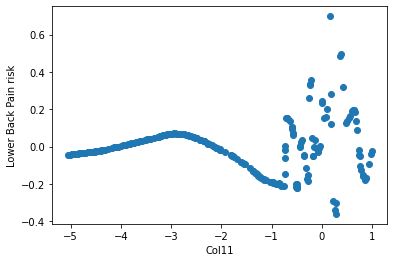

0.7467744648456573


In [39]:
def plotFeatureFunction(featureIndex):
  newOutput = outputs[featureIndex].detach().numpy()
  # newOutput = newOutput - (np.max(newOutput) + np.min(newOutput))/2
  meanOutput = np.mean(newOutput)
  newOutput = newOutput - meanOutput
  plt.scatter(inData[featureIndex], newOutput)
  plt.xlabel(trainingFeatureNames[featureIndex])
  plt.ylabel("Lower Back Pain risk")
  plt.show()
  return meanOutput

scoreOffSet = 0

for i in range(len(nets)):
  # plotFeatureFunction(i)
  scoreOffSet = scoreOffSet + plotFeatureFunction(i)
print(scoreOffSet)

## Accuracy

In [35]:
testingInput = testingSet[:,:12]
testingOutput = testingSet[:,12]
testingInput = testingInput.astype(np.float)
testingOutput = testingOutput.astype(np.float)
trainingFeatureNames = title[:-2] # TODO: Are we ending on index 12?
testData = {}
for i, feature in enumerate(trainingFeatureNames):
  testData[i] = torch.from_numpy(testingInput[:,i]).float().reshape(-1,1) # Can do by feature name or index
for i in testData:
  testData[i] = testData[i] / normalizationConstant[i] # normalization 

print(testingOutput)

[1. 1. 0. 0. 0. 1. 1. 1. 0. 0. 0. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 1. 0. 1.
 1. 1. 0. 1. 1. 1. 1. 1. 0. 1. 0. 0. 1. 1. 0. 1.]


#### Training Set Accuracy

In [31]:
totalOutNp = totalOut.detach().numpy()
totalOutNp = totalOutNp - 0.5
finalOut = np.ceil(totalOutNp).astype(np.int)
trainingOutputNp = trainingOutput.detach().numpy()
totalCorrect = 0
totalPoints =  trainingOutputNp.size
for i in range(totalPoints):
  if(finalOut[i] == trainingOutputNp[i]):
    totalCorrect += 1
print(totalCorrect/totalPoints)

0.9518518518518518


#### Testing Set Accuracy

In [36]:
prediction = [nets[i](testData[i]) for i in range(len(nets))]
totalOut = sum(prediction)
print(totalOut)

tensor([[ 0.7320],
        [ 0.7800],
        [ 0.5301],
        [ 0.1735],
        [-0.1264],
        [ 0.5841],
        [ 0.8618],
        [ 0.7892],
        [ 0.5657],
        [ 0.2533],
        [-0.3859],
        [ 0.5669],
        [-5.5855],
        [ 0.8293],
        [ 1.3248],
        [ 1.1328],
        [ 0.6423],
        [ 0.9240],
        [ 0.9671],
        [ 0.8291],
        [ 1.4410],
        [ 1.0022],
        [ 0.1999],
        [ 0.6648],
        [ 0.9474],
        [ 1.0610],
        [ 0.0186],
        [ 0.9495],
        [ 1.2036],
        [ 0.1636],
        [ 0.8951],
        [ 0.6029],
        [-0.2599],
        [-0.2010],
        [-0.0522],
        [ 0.5925],
        [ 1.2368],
        [ 0.8678],
        [ 0.2254],
        [ 0.8812]], grad_fn=<AddBackward0>)


In [37]:
totalOutNp = totalOut.detach().numpy()
totalOutNp = totalOutNp - 0.5
finalOut = np.ceil(totalOutNp).astype(np.int)
# testingOutputNp = testingOutput.detach().numpy()
totalCorrect = 0
totalPoints = totalOutNp.size
for i in range(totalPoints):
  if(finalOut[i] == testingOutput[i]):
    totalCorrect += 1
print(totalCorrect/totalPoints)

0.85
